In [10]:
#from mpl_toolkits import mplot3d
import pandas as pd
from numpy import array
import numpy as np
import h5py
from scipy.stats import pearsonr

import mplcursors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,

    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "computer-modern-roman",

    "figure.dpi": 300,
    "savefig.dpi": 300,
})


CMAPS = plt.colormaps
CMAP = CMAPS['hsv']

h = 0.6774  # co-moving constant


In [11]:
dat = pd.read_pickle('beta_data.pickle')

d_filt = dat['stars_mass_within_r50_stars'] <= 1e9

# Proximity to Nearest Galaxy

In [12]:

# def get_nearby(r_, delta_s):
#     return (
#         (r_[0] - delta_s < dat['Xc_ahf_cat']) & (dat['Xc_ahf_cat'] < r_[0] + delta_s) &
#         (r_[1] - delta_s < dat['Yc_ahf_cat']) & (dat['Yc_ahf_cat'] < r_[1] + delta_s) &
#         (r_[2] - delta_s < dat['Zc_ahf_cat']) & (dat['Zc_ahf_cat'] < r_[2] + delta_s)
#     )
    
# prox_to_nearest = np.zeros(dat.shape[0])
# nearest_galaxy = np.zeros(dat.shape[0])

# for i, row in enumerate(dat.itertuples()):
#     r_ = [getattr(row, f'{mu}c_ahf_cat') for mu in ('X', 'Y', 'Z')]
#     delta_s = 100
#     while sum(res := get_nearby(r_, delta_s)) <2:
#         delta_s += 100
    
    
#     r_nearest = np.inf # initial value
#     galaxy_nearest = -1
#     for nearby in dat[res].itertuples():
#         if nearby.galaxyID == row.galaxyID:
#             continue
        
#         r2_ = [getattr(nearby, f'{mu}c_ahf_cat') for mu in ('X', 'Y', 'Z')]
        
#         r_squared = 0
#         for s1, s2 in zip(r_, r2_):
#             diff = abs(s1 - s2)  # coordinate delta
#             # to account for the coordinate wrap-around (the universe repeats!)
#             diff = diff if diff < 7500 else 15000 - diff
#             r_squared += (diff)**2

#         r = np.sqrt(r_squared)
        
#         if r < r_nearest:
#             r_nearest = r
#             galaxy_nearest = nearby.galaxyID
    
#     prox_to_nearest[i] = r_nearest
#     nearest_galaxy[i] = galaxy_nearest
        
# dat['prox_to_nearest'] = prox_to_nearest
# dat['nearest_galaxy'] = nearest_galaxy


In [13]:
def get_nearest(row):
    
    r = np.array([
        row.Xc_ahf_cat, row.Yc_ahf_cat, row.Zc_ahf_cat
    ]).reshape((1, 3))
    
    r_other: np.ndarray = dat.loc[:, (
        'Xc_ahf_cat', 'Yc_ahf_cat', 'Zc_ahf_cat'
    )].to_numpy(dtype='float64')
    
    # 2d array: each row contains the x, y, z separation
    delta_r_vec = r_other - r
    
    # whether the coordinate is across the border
    is_over = delta_r_vec > 7500
    
    # if across the border, subtract delta_r from 15000
    delta_r_wrapped = (15000 - delta_r_vec) * is_over
    
    # else, use delta_r as is.
    delta_r_wrapped += delta_r_vec * ~is_over
    
    # find the magnitude
    delta_r_mag = np.sqrt((delta_r_wrapped**2).sum(axis=1))
    
    delta_r_mag += 15000 *(delta_r_mag == 0.0)
        
    nearest_galaxy = dat['galaxyID'].to_numpy(dtype=int)[delta_r_mag.argmin()]
    
    prox_to_nearest = delta_r_mag.min()
    
    return pd.Series(
        dict(
            galaxyID=row.galaxyID,
            nearest_galaxy=nearest_galaxy,
            d_comoving=prox_to_nearest,
            
            rvir_nearest=dat['Rvir_ahf_cat'].to_numpy(
                    dtype='float64'
                )[delta_r_mag.argmin()]
        )
    )

    
result = dat.apply(get_nearest, axis=1)


In [14]:

result

,galaxyID,nearest_galaxy,d_comoving,rvir_nearest
0,0.0,125.0,26.547945,13.27
1,1.0,31.0,40.816250,20.41
2,2.0,406.0,31.071614,15.53
3,3.0,865.0,43.348970,21.62
4,4.0,94.0,39.592948,19.80
...,...,...,...,...
1715,30409.0,18862.0,108.198608,14.37
1716,31281.0,18.0,66.546746,51.54
1717,35974.0,2550.0,75.538895,32.50
1718,46322.0,165.0,98.207674,57.62


In [15]:
dat = dat.merge(result)

Text(0, 0.5, 'Y (Mpc)')

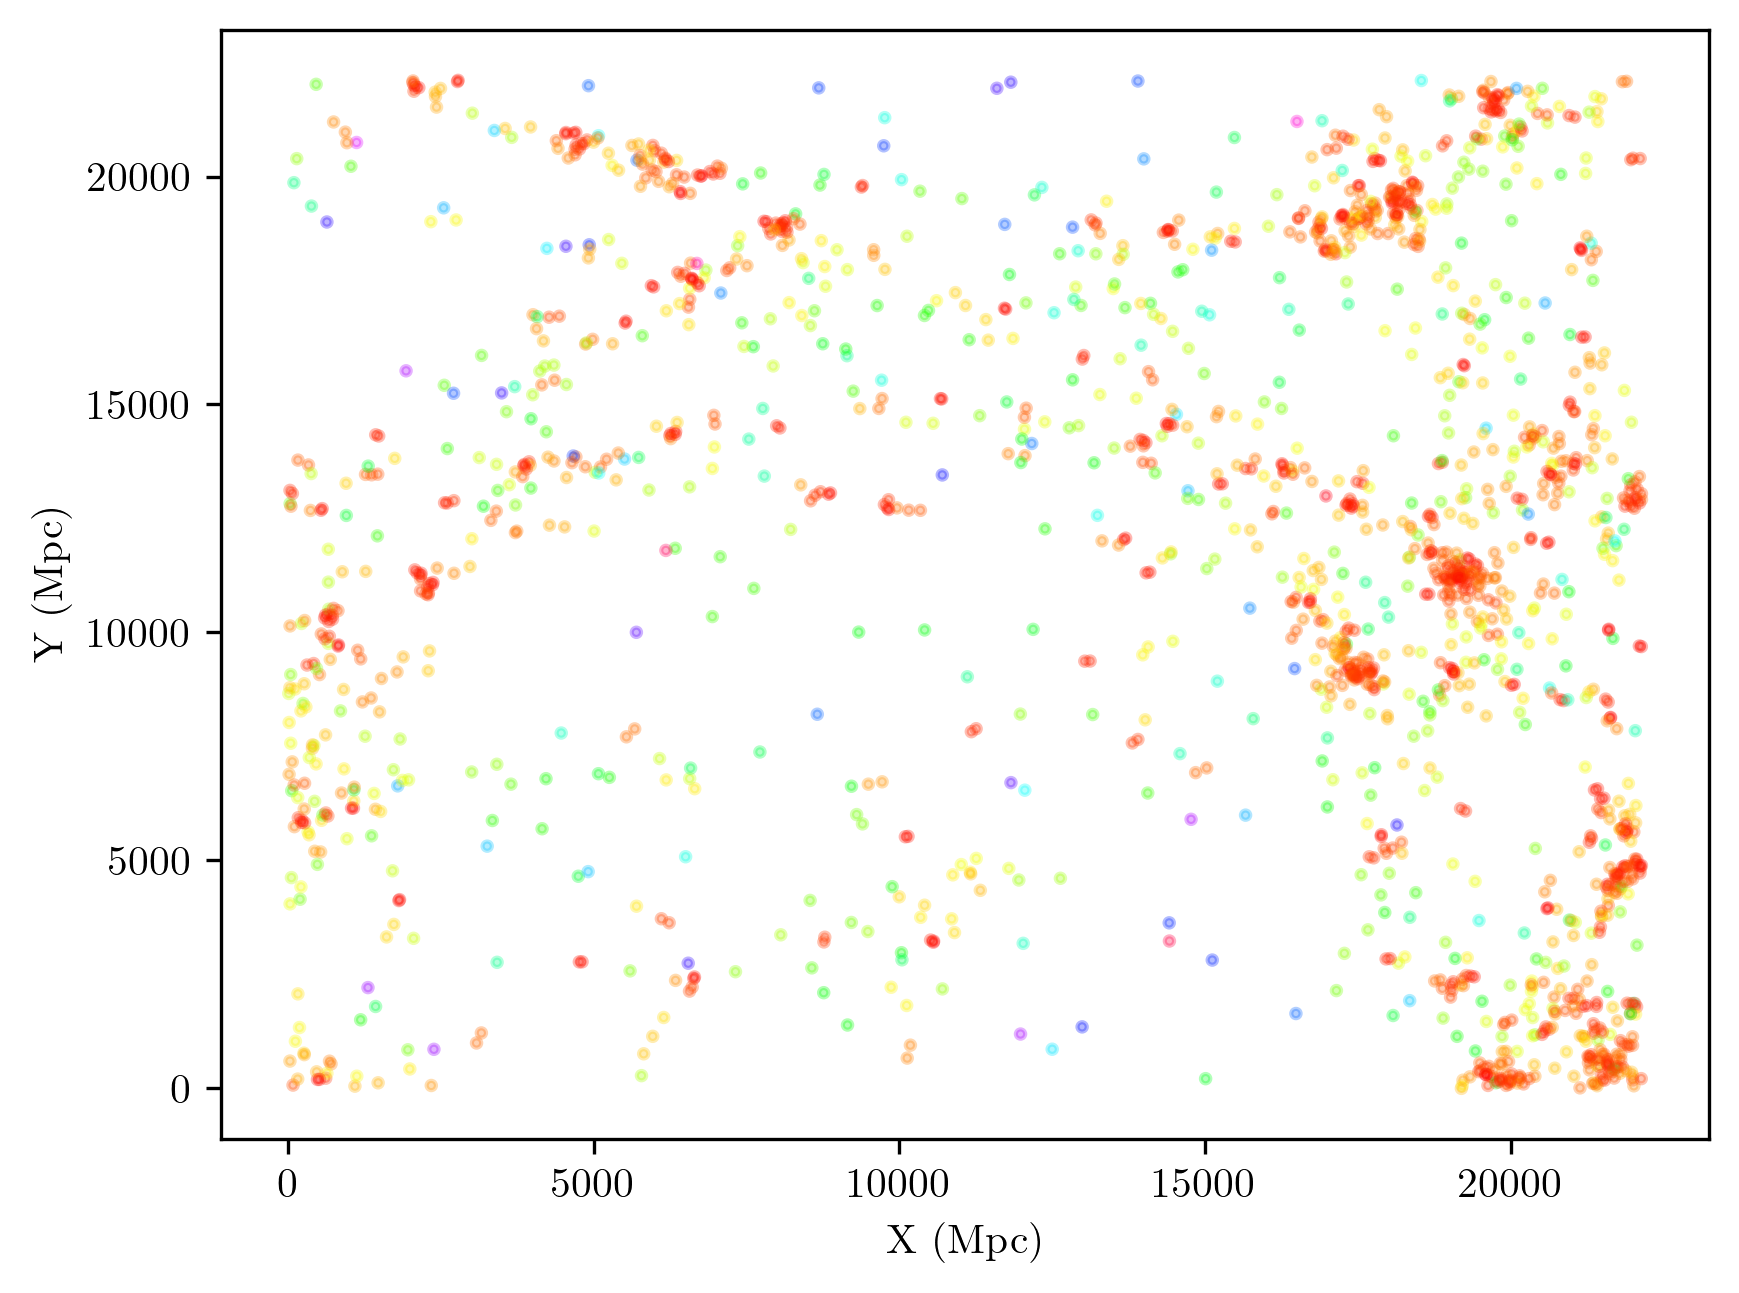

In [16]:
%matplotlib inline
fig, ax = plt.subplots()

x, y, z = dat['X_Mpc_ahf_cat'], dat['Y_Mpc_ahf_cat'], dat['Z_Mpc_ahf_cat']

_size = 5


_mappable = ax.scatter(
    y, z,
    alpha=0.3,
    s=_size,
    c=dat['d_comoving'],
    cmap=CMAP
)

# fig.colorbar(_mappable, label=r'$\beta$')
# ax.set_xlim((0 / h, 15000 / h))
# ax.set_ylim((0 / h, 10000 / h))
ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')

# ax.legend(('Hosts', 'Satellites'))



(PearsonRResult(statistic=-0.26189655777191156, pvalue=1.4463440899288755e-21),
 PearsonRResult(statistic=-0.2791174912037076, pvalue=3.138569088535724e-24))

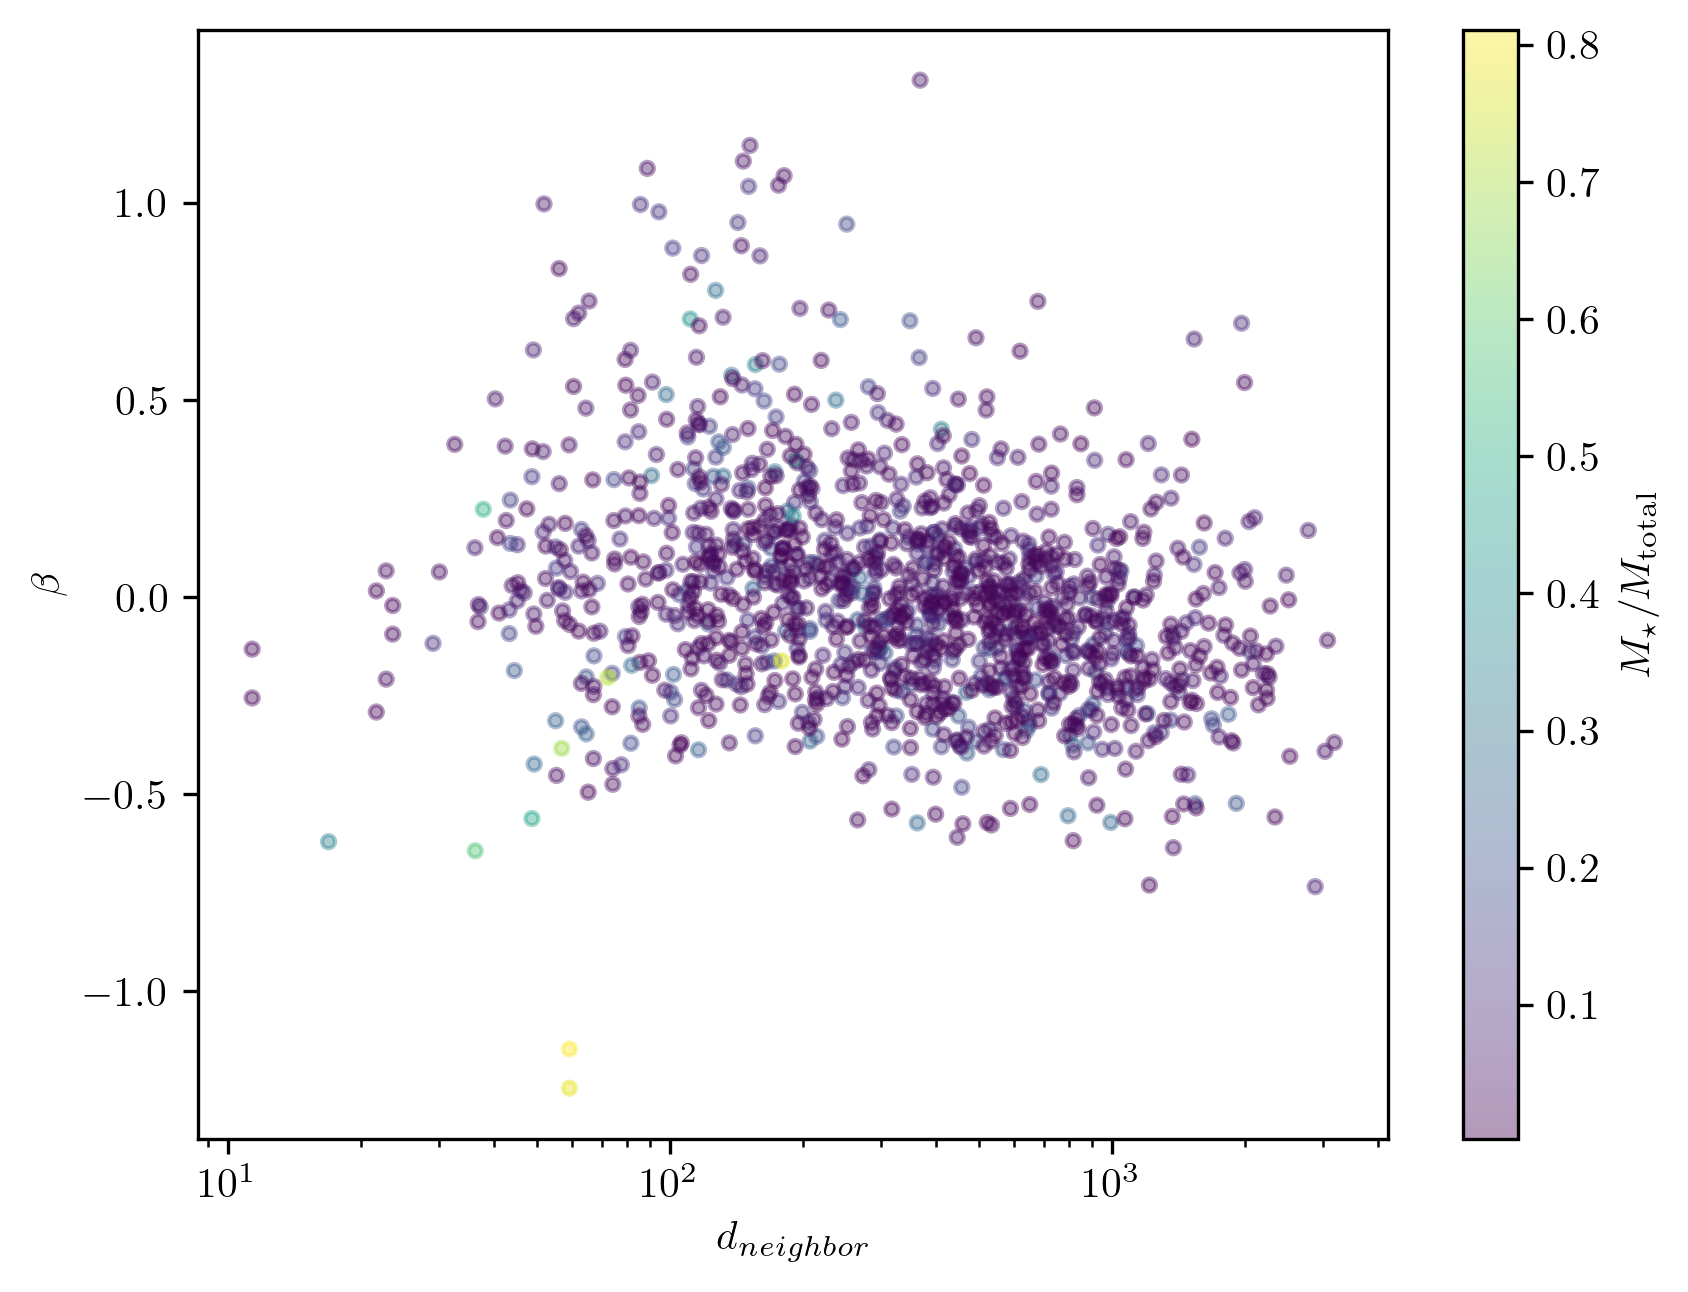

In [18]:
fig, (ax1) = plt.subplots()

# fig.set_figwidth(12)
# fig.set_figheight(4)

_scatter = ax1.scatter(
    dat[d_filt]['d_comoving'] / h,
    dat[d_filt]['beta_r50'],
    s=10,
    marker='o',
    c=dat[d_filt]['M_\star/M_tot'],
    alpha=0.4
)

ax1.set_xlabel(r'$d_{neighbor}$')
ax1.set_ylabel(r'$\beta$')

ax1.set_xscale('log')


# ax2.scatter(
#     dat[d_filt]['d_comoving'] / dat[d_filt]['rvir_nearest'],
#     dat[d_filt]['beta_r50'],
#     s=10,
#     marker='^',
#     c=dat[d_filt]['M_*/M_tot']
# )

# ax2.set_xlabel(r'$d_{neighbor}/R_{vir}$')
# ax2.set_ylabel(r'$\beta$')

# ax2.set_xscale('log')


cbar = fig.colorbar(_scatter, ax=[ax1])
cbar.set_label(r'$M_\star/M_{\rm{total}}$')


fig.savefig('paper/figs/me/beta-d_nearest.pdf')


vir_filt = d_filt & (dat[d_filt]['d_comoving']/ dat[d_filt]['rvir_nearest'] > 0.2)

(
    pearsonr(
        np.log(dat[d_filt]['d_comoving'] /h),
        dat[d_filt]['beta_r50']
    ),
    pearsonr(
        np.log(dat[vir_filt]['d_comoving']),
        dat[vir_filt]['beta_r50']
    )
)